# Execute aqui primeiro

In [1058]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np

In [1059]:
files = os.listdir("imgs/")

files = [f for f in files if os.path.isfile(os.path.join("imgs/", f))]

In [1060]:
def plot_imgs(imgs):
    n = len(imgs)//3
    
    fig, axes = plt.subplots(n, n, figsize=(15, 15))
    axes = np.ravel(axes)

    for i, ax in enumerate(axes):
        if i < len(imgs):
            
            img = imgs[i][1]
            
            if len(img.shape) == 3 and img.shape[2] == 3:
                ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            else:
                ax.imshow(img, cmap='gray')

            ax.set_title(imgs[i][0])
            
        ax.axis('off')

In [1061]:
def plot_two_img(imgs):
    
    ig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(cv.cvtColor(imgs[0], cv.COLOR_BGR2RGB))
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(cv.cvtColor(imgs[1], cv.COLOR_BGR2RGB))
    axes[1].set_title("Segmentação")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [1062]:
def preprocess_image_for_segmentation(image_path, hsv = [False, False, False], dilate = False, erode = False):
    
    img_original = cv.imread(image_path)
    
    if img_original is None:
        print(f"Erro ao carregar a imagem: {image_path}")
        return None

    img_hsv = cv.cvtColor(img_original, cv.COLOR_BGR2HSV)

    img_denoised = cv.medianBlur(img_hsv, 5)

    h, s, v = cv.split(img_denoised)

    h = np.uint8(h)
    s = np.uint8(s)
    v = np.uint8(v)

    if (hsv[0]):
        h = cv.equalizeHist(h)
    
    if (hsv[1]):
        s = cv.equalizeHist(s)
    
    if (hsv[2]):
        v = cv.equalizeHist(v)

    img_hsv_equalized = cv.merge([h, s, v])

    img_bgr = cv.cvtColor(img_hsv_equalized, cv.COLOR_HSV2BGR)
    img_processed = img_bgr.copy()

    kernel = np.ones((5, 5), np.uint8)

    #img_processed = cv.morphologyEx(img_processed, cv.MORPH_OPEN, kernel, iterations=1)
    #img_processed = cv.morphologyEx(img_processed, cv.MORPH_CLOSE, kernel, iterations=1)

    if erode:
        img_processed = cv.erode(img_processed, kernel, iterations=1)

    if dilate:
        img_processed = cv.dilate(img_processed, kernel, iterations=1)

    return img_processed

# Segmentação com Watershed

In [1063]:
def threshold(img):
    gray = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
    gray = cv.GaussianBlur(gray, (3, 3), 0)

    return cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

In [1064]:
def sure_bg(th):
    
    kernel = np.ones((3, 3), np.uint8)
    opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=2)

    return cv.dilate(opening, kernel, iterations=3)

In [1065]:
def dist_transform (th):

    kernel = np.ones((3, 3), np.uint8)
    opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=2)
    
    return cv.distanceTransform(opening, cv.DIST_L2, 5)

In [1066]:
def sure_fg(dist):
    
    _, sure_fg = cv.threshold(dist, 0.7 * dist.max(), 255, 0)
    
    return np.uint8(sure_fg)

In [1067]:
def markers (fg, unknown):

    _, m = cv.connectedComponents(fg)
    m = m + 1
    m[unknown == 255] = 0
    
    return m

In [1073]:
def image_segmentation_with_watershed(file_path, preprocess = False, hsv = [False, False, False], dilate = False, erode = False):

    img_original = cv.imread(file_path)
    
    img = img_original.copy()

    if preprocess:
        img = preprocess_image_for_segmentation(file_path, hsv, dilate, erode)

    _, th = threshold(img)
    bg = sure_bg(th)
    dist = dist_transform(th)
    fg = sure_fg(dist)
    
    unknown = cv.subtract(bg, fg)

    m = markers(fg, unknown)
    
    seq_img, wm = watershed(img, m)

    image_with_contours = img_original.copy()
    contours = np.uint8(wm == -1)
    image_with_contours[contours == 1] = [0, 0, 255]

    result = []
    result.append(("Original", img_original))
    result.append(("Theshold", th))
    result.append(("Sure bg", bg))
    result.append(("Distance Transform", dist))
    result.append(("Sure fg", fg))
    result.append(("Unknown", unknown))
    result.append(("Makers", m))
    result.append(("Watershed", seq_img))
    result.append(("Segment resul", image_with_contours))
    
    
    plot_imgs(result)
    
    return image_with_contours

In [1074]:
for i in range(len(files)):
    path = "imgs/" + files[i]
    print(f"result = image_segmentation_with_watershed('{path}')")

result = image_segmentation_with_watershed('imgs/beans.png')
result = image_segmentation_with_watershed('imgs/blobs.png')
result = image_segmentation_with_watershed('imgs/chips.png')
result = image_segmentation_with_watershed('imgs/coffee.png')
result = image_segmentation_with_watershed('imgs/dowels.tif')
result = image_segmentation_with_watershed('imgs/flowers.jpg')
result = image_segmentation_with_watershed('imgs/gecko.png')
result = image_segmentation_with_watershed('imgs/rice.tif')


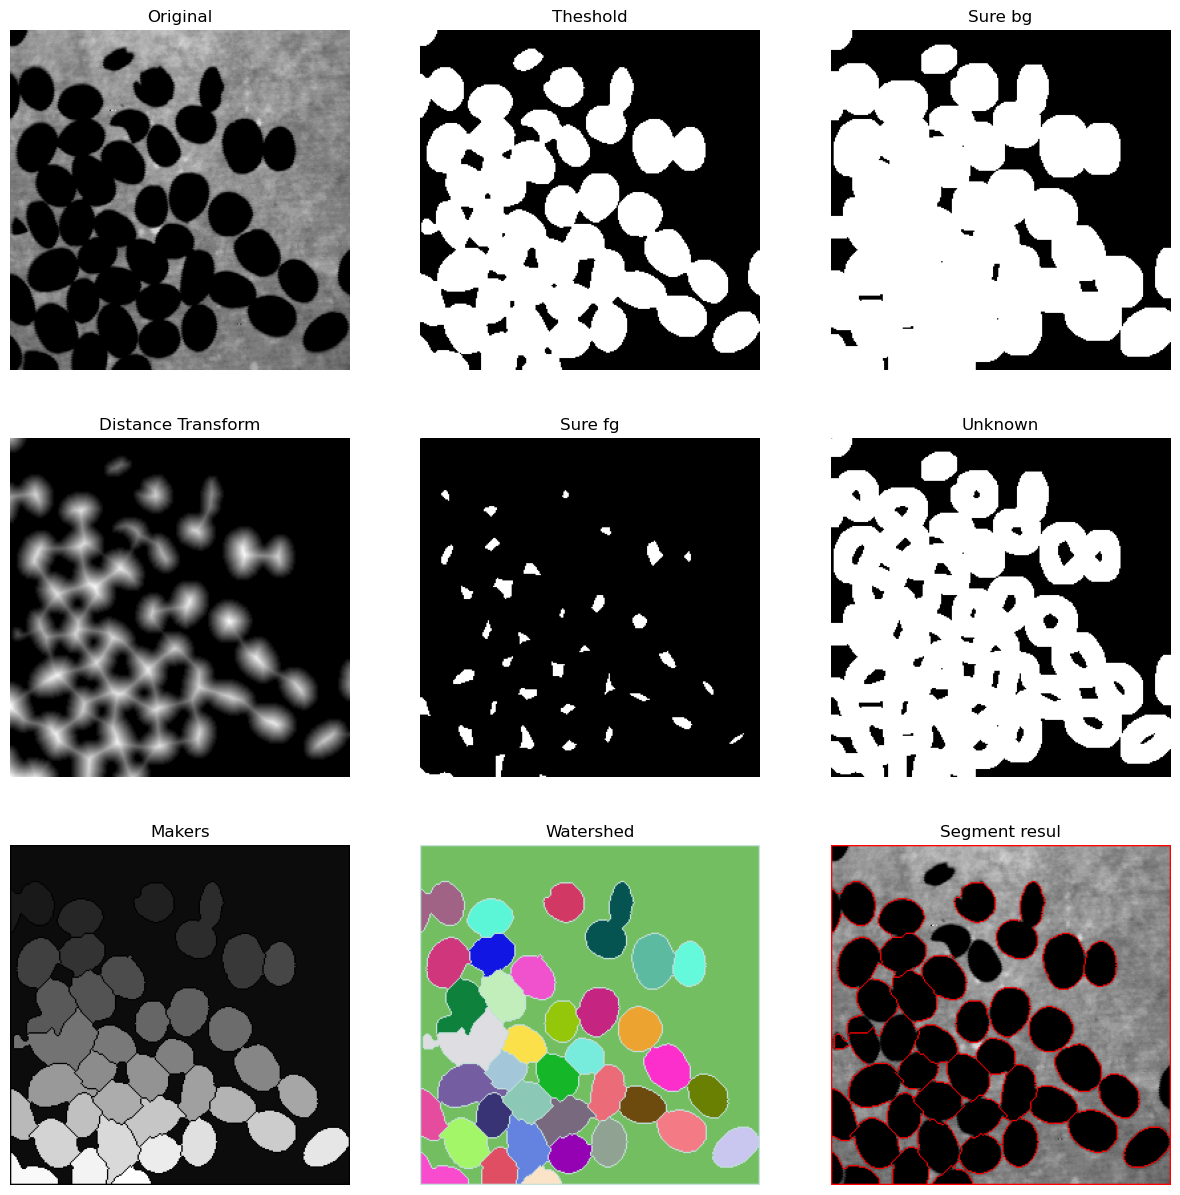

In [1075]:
result = image_segmentation_with_watershed('imgs/beans.png', True, [True, True, False])

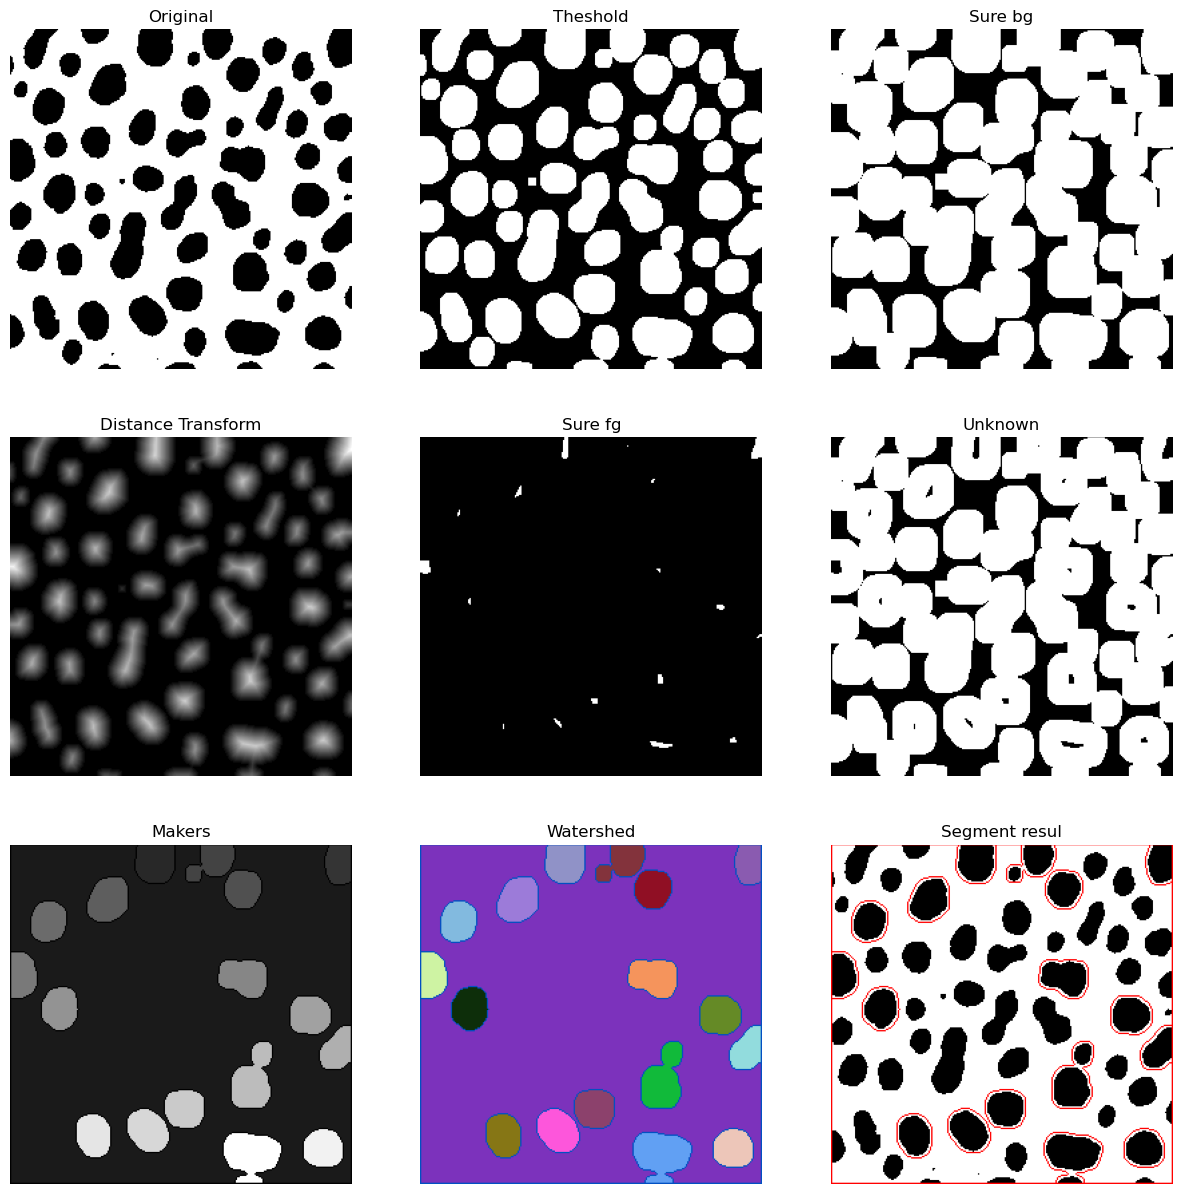

In [1080]:
result = image_segmentation_with_watershed('imgs/blobs.png', True, [False, False, True], erode = True)

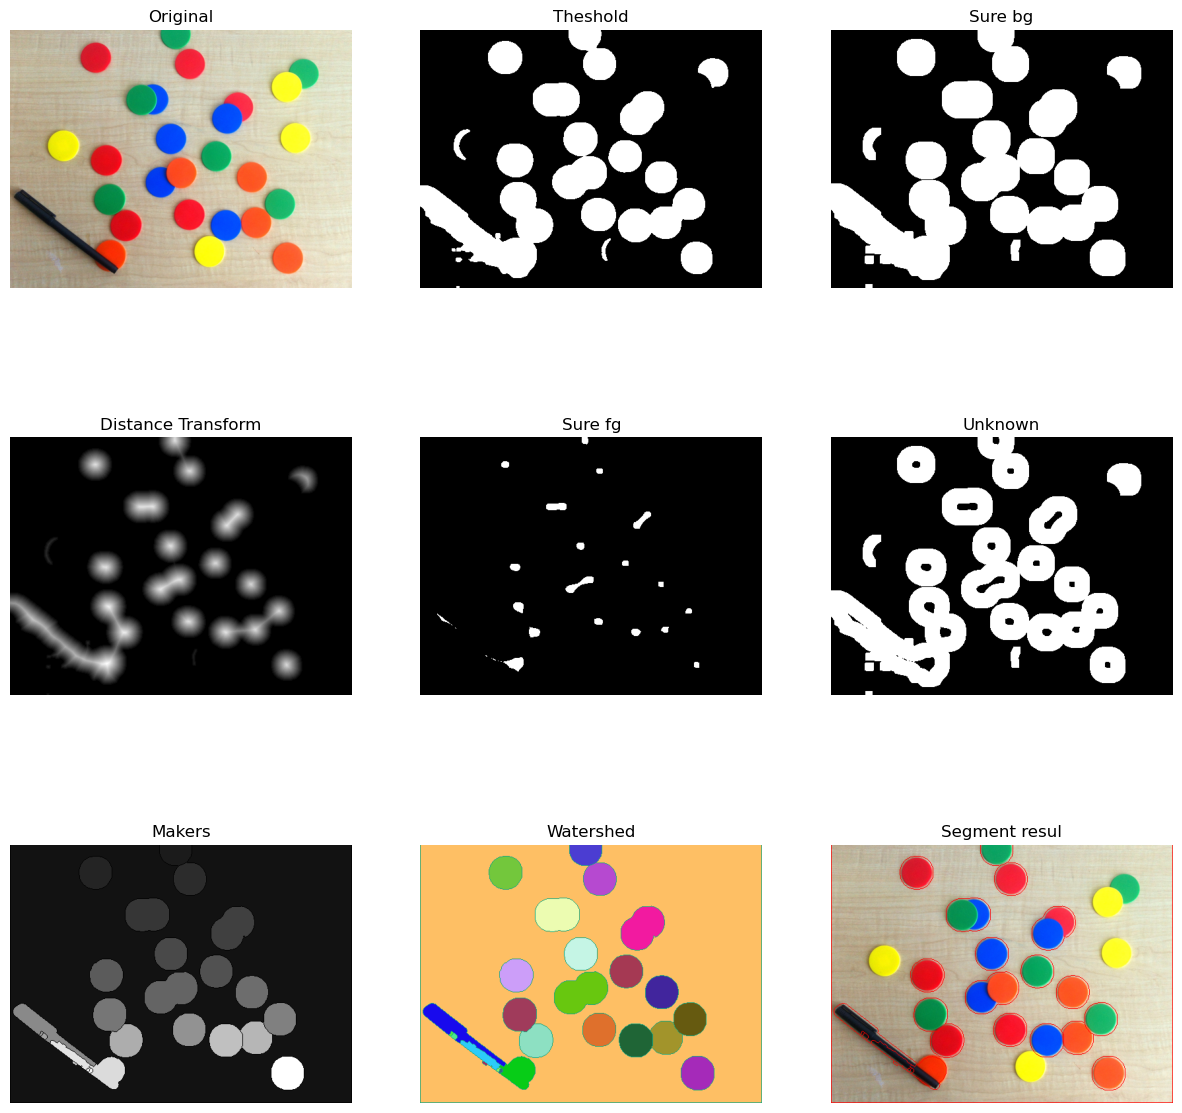

In [1086]:
result = image_segmentation_with_watershed('imgs/chips.png', True, erode = True)

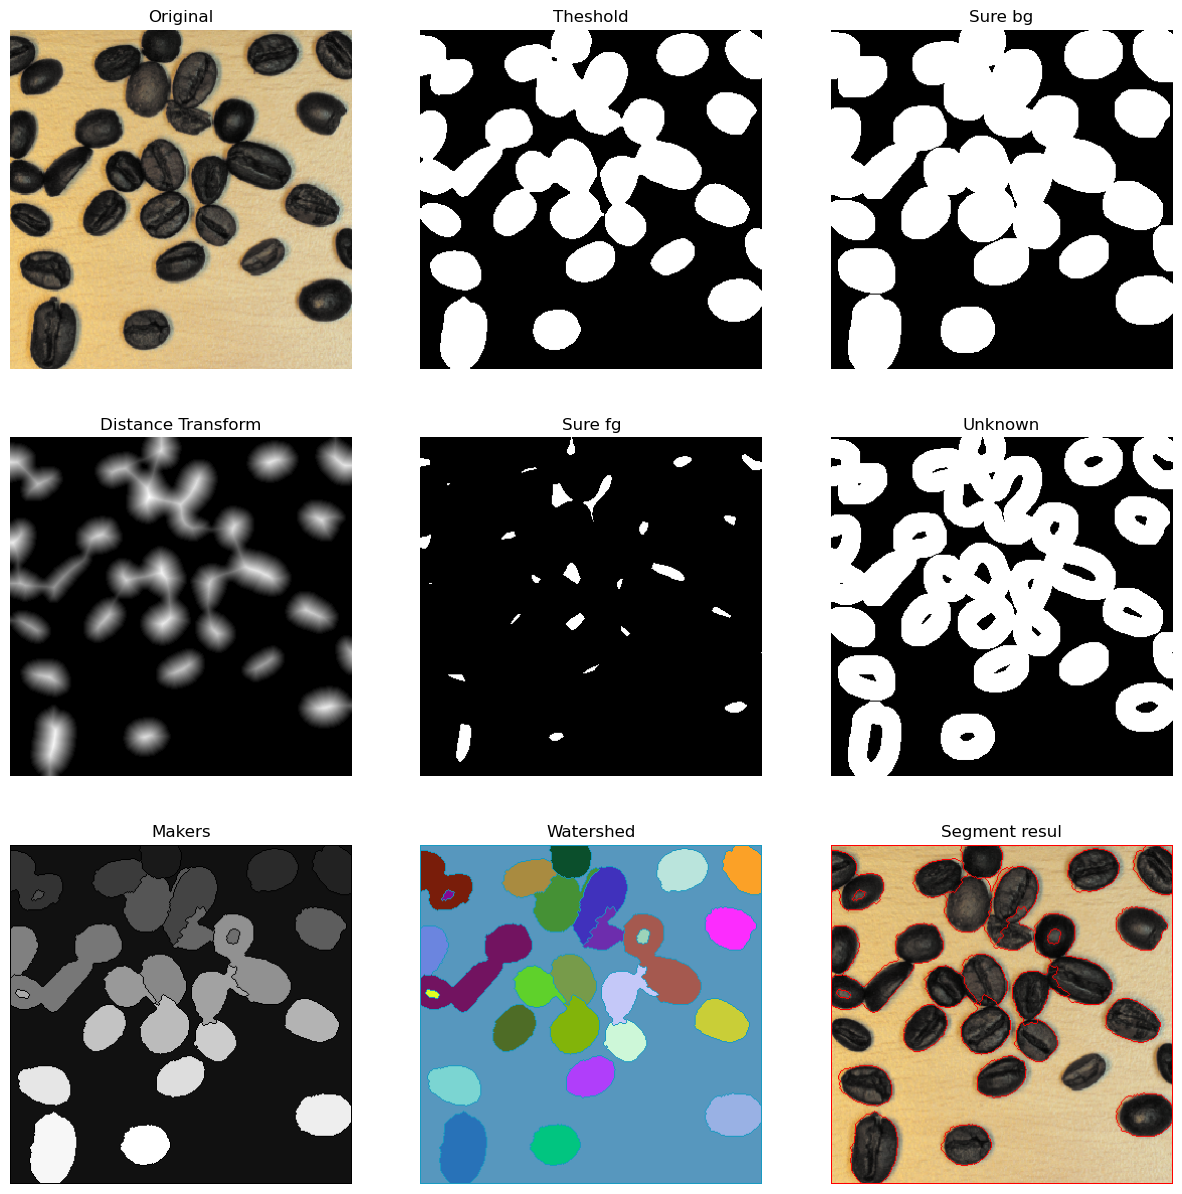

In [1021]:
result = image_segmentation_with_watershed('imgs/coffee.png', True)

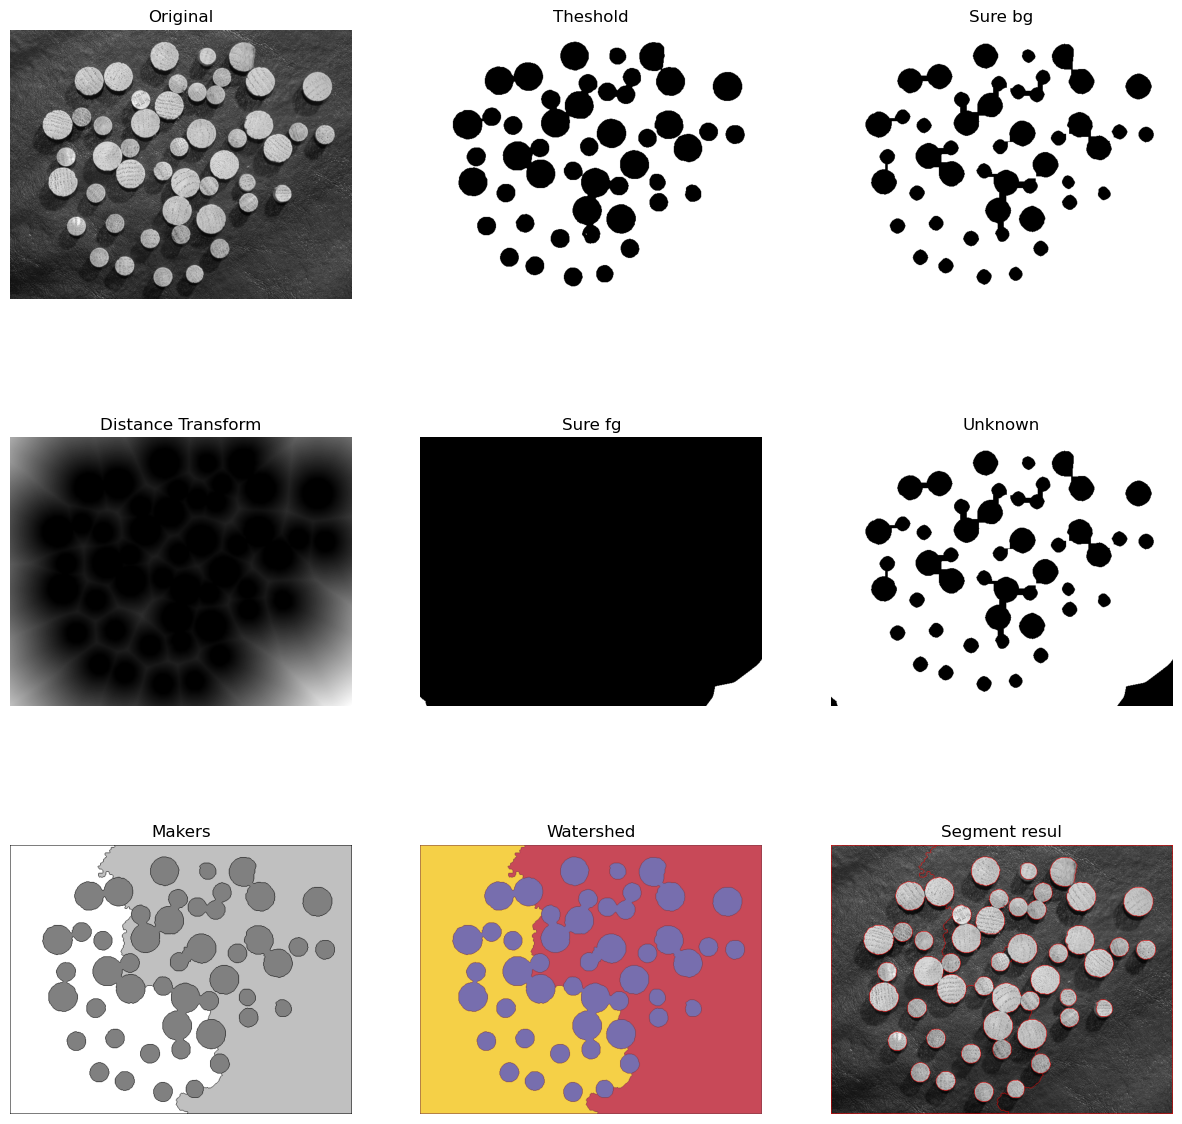

In [1092]:
result = image_segmentation_with_watershed('imgs/dowels.tif', True, [False, False, False], dilate = True, erode = True)

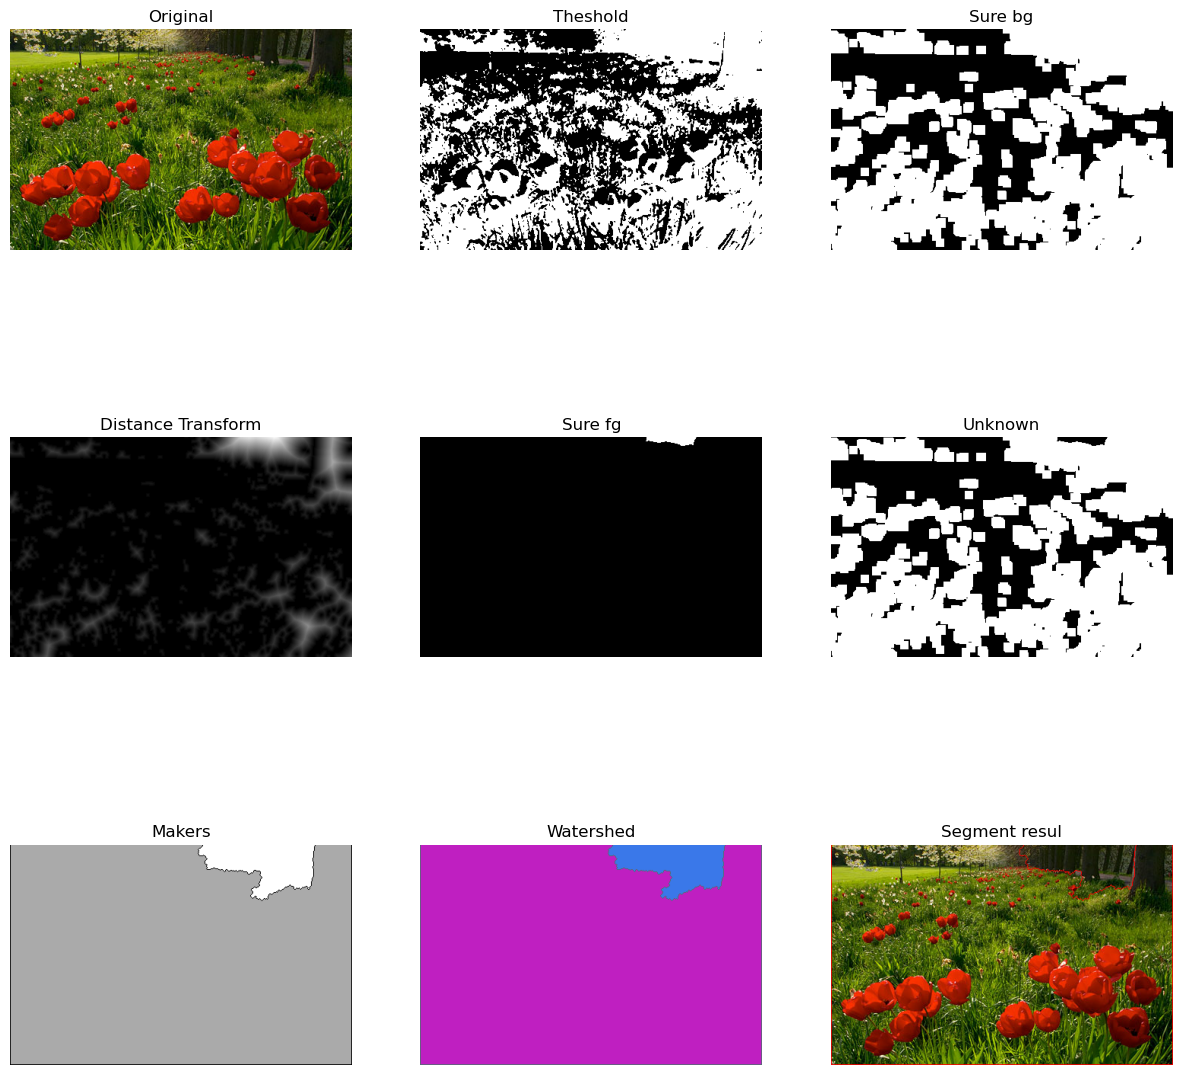

In [1094]:
result = image_segmentation_with_watershed('imgs/flowers.jpg', erode = True)

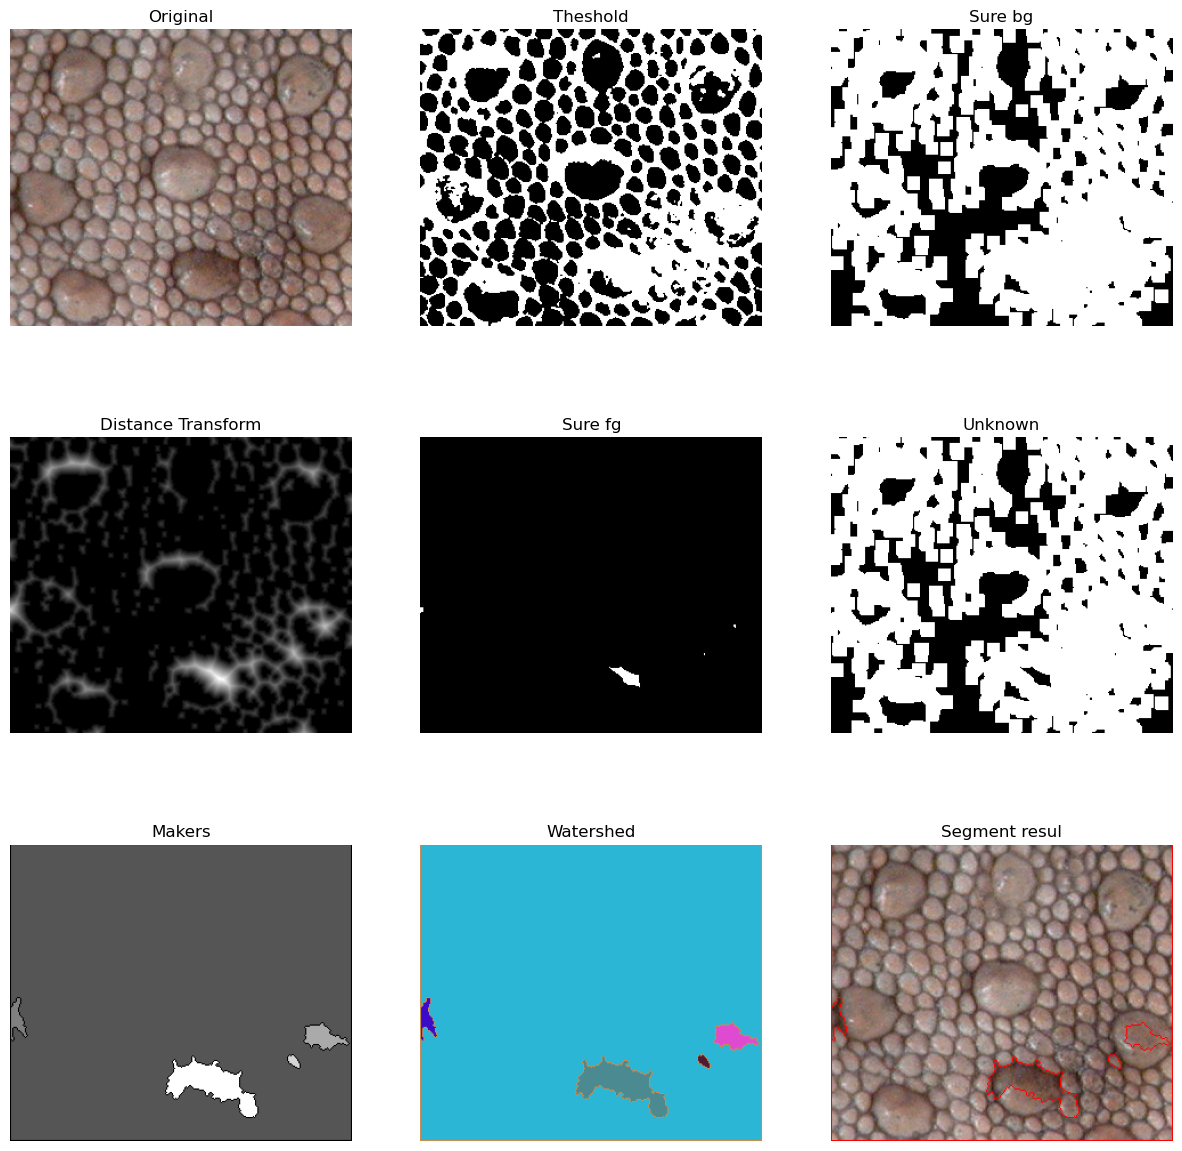

In [1098]:
result = image_segmentation_with_watershed('imgs/gecko.png', hsv = [False, False, True], dilate = False, erode = True)

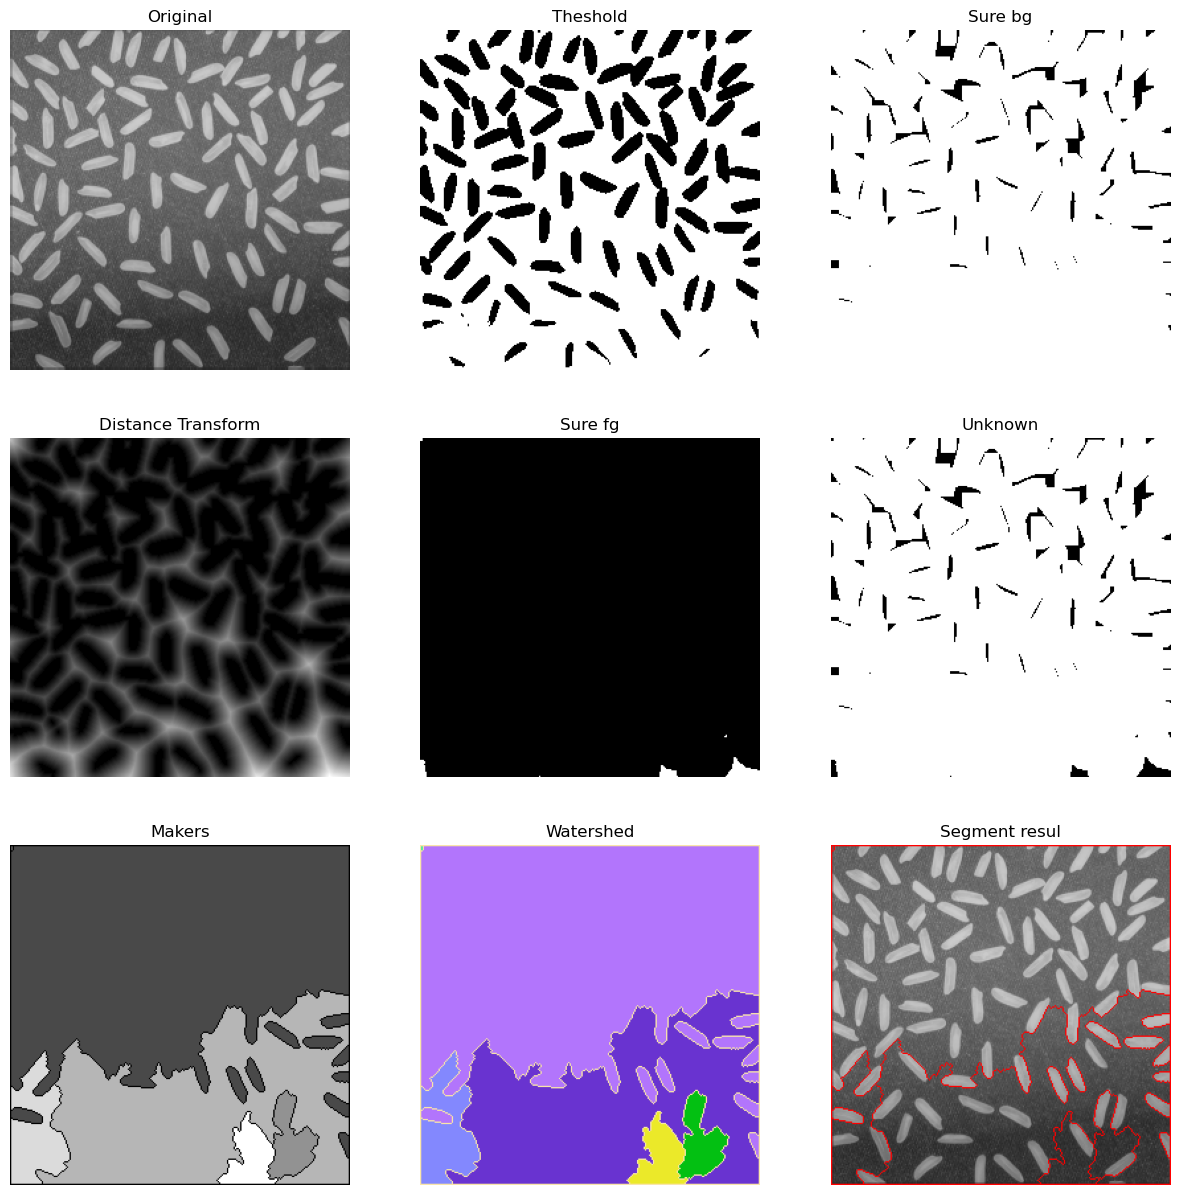

In [1039]:
result = image_segmentation_with_watershed('imgs/rice.tif', False, [False, False, False])